In [1]:
#Import Modules
import bs4 as bs
import pickle
import requests
import datetime as dt
import os
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like #Prevents "is_list_like" error when importing pandas_datareader
import pandas_datareader.data as web
import time
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
%matplotlib notebook

In [2]:
#Pull Ticker names of S&P 500 companies off of Wikipedia 

def save_sp500_tickers():
    tickers = []
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)

    with open("sp500tickers.pickle","wb") as f:
#Remove faulty Tickers/lack of information before storing ticker data into file
        tickers.remove("ANDV")
        tickers.remove("BKNG")
        tickers.remove("BHF")
        tickers.remove("CBRE")
        tickers.remove("DWDP")
        tickers.remove("DXC")
        tickers.remove("EVRG")
        tickers.remove("JEF")
        tickers.remove("TPR")
        tickers.remove("UAA")
        tickers.remove("WELL")
        pickle.dump(tickers,f)
        

save_sp500_tickers()

In [3]:
#Pulling data of all S&P 500 companies from morningstar (With the exception of: ANDV, BKNG, BHF, CBRE, DWDP, DXC,
                                                        #EVRG, JEF, TPR, UAA, WELL)
def get_data_from_morningstar(reload_sp500=False):
#Reload = True to rerun and pull updated/current data
    if reload_sp500:
        tickers = save_sp500_tickers()
    else:
#Else pull data from local drive to avoid data collection runtime
        with open("sp500tickers.pickle", "rb") as f:
            tickers = pickle.load(f)
    if not os.path.exists("stock_dfs"):
        os.makedirs("stock_dfs")
#Generate start and end range for data colletion
    start = dt.datetime(2010, 1, 1)
    end = dt.datetime.now()

    for ticker in tickers:
        #Create a local storage of stock data on harddrive in case of broken connection with morningstar
        if not os.path.exists("stock_dfs/{}.csv".format(ticker)):
            print(ticker)
            df = web.DataReader(ticker, "morningstar", start, end)
            df.reset_index(inplace=True)
            df.set_index("Date", inplace=True)
            df = df.drop("Symbol", axis=1)
            df.to_csv("stock_dfs/{}.csv".format(ticker))
            time.sleep(.5)  #Implement time.sleep function to avoid being throttled by morningstar servers
            
        else:
            print('Already have {}'.format(ticker))
            
            


get_data_from_morningstar()

Already have MMM
Already have ABT
Already have ABBV
Already have ABMD
Already have ACN
Already have ATVI
Already have ADBE
Already have AMD
Already have AAP
Already have AES
Already have AET
Already have AMG
Already have AFL
Already have A
Already have APD
Already have AKAM
Already have ALK
Already have ALB
Already have ARE
Already have ALXN
Already have ALGN
Already have ALLE
Already have AGN
Already have ADS
Already have LNT
Already have ALL
Already have GOOGL
Already have GOOG
Already have MO
Already have AMZN
Already have AEE
Already have AAL
Already have AEP
Already have AXP
Already have AIG
Already have AMT
Already have AWK
Already have AMP
Already have ABC
Already have AME
Already have AMGN
Already have APH
Already have APC
Already have ADI
Already have ANSS
Already have ANTM
Already have AON
Already have AOS
Already have APA
Already have AIV
Already have AAPL
Already have AMAT
Already have APTV
Already have ADM
Already have ARNC
Already have AJG
Already have AIZ
Already have T


In [4]:
#Load and compile individual stock data into DataFrame: "sp500"
def compile_data():
    with open("sp500tickers.pickle", "rb") as f:
        tickers = pickle.load(f)

    sp500 = pd.DataFrame()

    for count, ticker in enumerate(tickers):
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
#Set date as primary index
        df.set_index('Date', inplace=True)
#Rename column "Close" with ticker value and delete "Open", "High", "Low", and "Volume"
        df.rename(columns={"Close": ticker}, inplace=True)
        df.drop(columns = ["Open", "High", "Low", "Volume"], inplace=True)

        if sp500.empty:
            sp500 = df
        else:
            sp500 = sp500.join(df, how="outer")

#Create a sp500 DataFrame copy on hard drive
    sp500.to_csv("sp500_joined_closes.csv")


compile_data()

           MMM       ABT      ABBV      ABMD       ACN      ATVI      ADBE  \
MMM   1.000000  0.926218  0.905366  0.800974  0.956808  0.923503  0.910622   
ABT   0.926218  1.000000  0.946198  0.815761  0.928179  0.859140  0.895464   
ABBV  0.905366  0.946198  1.000000  0.864703  0.902830  0.882034  0.919806   
ABMD  0.800974  0.815761  0.864703  1.000000  0.886019  0.930104  0.965952   
ACN   0.956808  0.928179  0.902830  0.886019  1.000000  0.949950  0.945415   

           AMD       AAP       AES    ...         WYNN       XEL       XRX  \
MMM   0.396412  0.680518 -0.059020    ...     0.262687  0.951793  0.548503   
ABT   0.241062  0.674316  0.039580    ...     0.341154  0.866986  0.500815   
ABBV  0.697757  0.111427 -0.269698    ...     0.160552  0.772982  0.317731   
ABMD  0.593735  0.415292 -0.185283    ...     0.180204  0.798299  0.230268   
ACN   0.402838  0.656759 -0.130708    ...     0.219487  0.953878  0.358786   

          XLNX        XL       XYL       YUM       ZBH      ZI

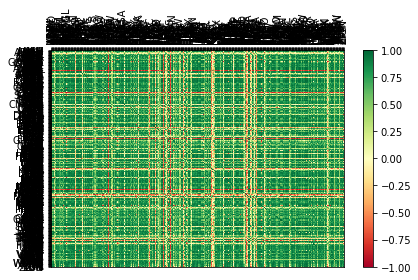

In [5]:
#Create correlation table using pandas correlation function

def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    df_corr = df.corr()
    print(df_corr.head())
    df_corr.to_csv('sp500corr.csv')
    
    
#Graph correlation table using pyplot on a heatmap
    data1 = df_corr.values
    fig1 = plt.figure()
    ax1 = fig1.add_subplot(111)
#RGB value for heatmap
    heatmap1 = ax1.pcolor(data1, cmap=plt.cm.RdYlGn)
    fig1.colorbar(heatmap1)
#Defining axis parameters
    ax1.set_xticks(np.arange(data1.shape[1]) + 0.5, minor=False)
    ax1.set_yticks(np.arange(data1.shape[0]) + 0.5, minor=False)
    ax1.invert_yaxis()
    ax1.xaxis.tick_top()
    column_labels = df_corr.columns
    row_labels = df_corr.index
    ax1.set_xticklabels(column_labels)
    ax1.set_yticklabels(row_labels)
    plt.xticks(rotation=90)
    heatmap1.set_clim(-1,1)
    plt.tight_layout()
    plt.savefig("correlations.png", dpi = (300))
    plt.show()

visualize_data()

In [6]:
#Analyzing our data using percentage change to try and see which companies lag
def process_labels(ticker):
    days = 5
    df = pd.read_csv('sp500_joined_closes.csv', index_col=0)
    tickers = df.columns.values.tolist()
    df.fillna(0, inplace=True)
#shifting the columns up by 5 to create business week percentage change data, comparing the price of a stock at the
#beginning of the week with the price at the end of the week
    for i in range(1, days+1):
        df['{}_{}d'.format(ticker,i)] = (df[ticker].shift(-i) - df[ticker]) / df[ticker]

    df.fillna(0, inplace=True)
    return tickers, df

In [7]:
#Defining our parameters, buy/sell/hold, a 2% or greater positive change in 5 days results in a buy label
                                        # a 2% or greater fall results in sell and hold is between -2 and 2% change
def buy_sell_hold(*args):
    cols = [c for c in args]
    for col in cols:
        if col > 0.02:
            return 1
        if col < -0.02:
            return -1
    return 0

In [8]:
from collections import Counter

In [9]:
#Using "process_labels" function, grab percent change data for a company of our choice, using its ticker value, and
#run our paramaters "buy_sell_hold" over it to generate buy/sell/hold condition
def featuresets(ticker):
    tickers, df = process_labels(ticker)

    df['{}_target'.format(ticker)] = list(map( buy_sell_hold,
                                               df['{}_1d'.format(ticker)],
                                               df['{}_2d'.format(ticker)],
                                               df['{}_3d'.format(ticker)],
                                               df['{}_4d'.format(ticker)],
                                               df['{}_5d'.format(ticker)], ))
#Cleaning up our data
    vals = df['{}_target'.format(ticker)].values.tolist()
    str_vals = [str(i) for i in vals]
    print('Data spread:',Counter(str_vals))
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], np.nan)
    df.dropna(inplace=True)
    df_vals = df[[ticker for ticker in tickers]].pct_change()
    df_vals = df_vals.replace([np.inf, -np.inf], 0)
    df_vals.fillna(0, inplace=True)
    X = df_vals.values
    y = df['{}_target'.format(ticker)].values
#Return feauturesets and labels to be used for machine learning
    return X,y,df

featuresets("XOM")

Data spread: Counter({'0': 1212, '1': 524, '-1': 495})


(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.0042337 ,  0.00870599,  0.        , ...,  0.01539503,
          0.03897116,  0.        ],
        [-0.00626355, -0.00808206,  0.        , ...,  0.03165611,
          0.03525881,  0.        ],
        ...,
        [ 0.00064334,  0.03105096, -0.01058589, ..., -0.0121308 ,
          0.02035432,  0.00209864],
        [-0.00296736, -0.01498069, -0.04713983, ..., -0.00124577,
         -0.01736239, -0.00616638],
        [ 0.00173611, -0.00721229, -0.01156198, ..., -0.0051675 ,
         -0.00357143, -0.00152189]]),
 array([1, 0, 0, ..., 0, 0, 0]),
                MMM      ABT   ABBV    ABMD     ACN    ATVI    ADBE    AMD  \
 Date                                                                        
 2010-01-01   82.67  25.8328   0.00    8.73   41.50  11.110   36.78   9.68   
 2010-01-04   83.02  26.0577   0.00    8.74   42.07  11.300   37.09   9.70   
 2010-01-05   82.50  25.8471

In [10]:
from sklearn import svm, cross_validation, neighbors
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from statistics import mean

/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [11]:
#Machine Learning
def machine_learning(ticker):
    X, y, df = featuresets(ticker)
#use cross validation function to "train" our computer
    X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size=0.25)

    clf = VotingClassifier([('lsvc', svm.LinearSVC()),
                            ('knn', neighbors.KNeighborsClassifier()),
                            ('rfor', RandomForestClassifier())])
#Return accuracy and prediction (Buy(1), Hold(0), Sell(-1))
    clf.fit(X_train, y_train)
    confidence = clf.score(X_test, y_test)
    print('accuracy:', confidence)
    predictions = clf.predict(X_test)
    print('predicted class counts:', Counter(predictions))
    print()
    print()
    return confidence

machine_learning("FB")

Data spread: Counter({'0': 1032, '1': 696, '-1': 503})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.5026929982046678
predicted class counts: Counter({0: 411, 1: 78, -1: 68})




/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


0.5026929982046678

In [12]:
#Parse over all stocks and run predictions and check accuracies
with open("sp500tickers.pickle","rb") as f:
    tickers = pickle.load(f)

accuracies = []
for count,ticker in enumerate(tickers):

    if count%10==0:
        print(count)

    accuracy = machine_learning(ticker)
    accuracies.append(accuracy)
    print("{} accuracy: {}. Average accuracy:{}".format(ticker,accuracy,mean(accuracies)))

0
Data spread: Counter({'0': 1209, '1': 581, '-1': 441})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.5304659498207885


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


predicted class counts: Counter({0: 507, -1: 38, 1: 13})


MMM accuracy: 0.5304659498207885. Average accuracy:0.5304659498207885
Data spread: Counter({'0': 1115, '1': 636, '-1': 480})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.46415770609318996


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


predicted class counts: Counter({0: 498, -1: 39, 1: 21})


ABT accuracy: 0.46415770609318996. Average accuracy:0.49731182795698925
Data spread: Counter({'0': 1219, '1': 587, '-1': 425})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.5385996409335727


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


predicted class counts: Counter({0: 480, -1: 64, 1: 13})


ABBV accuracy: 0.5385996409335727. Average accuracy:0.511074432282517
Data spread: Counter({'1': 1123, '-1': 784, '0': 324})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.3888888888888889


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


predicted class counts: Counter({1: 329, -1: 229})


ABMD accuracy: 0.3888888888888889. Average accuracy:0.48052804643411
Data spread: Counter({'0': 1006, '1': 707, '-1': 518})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.4265232974910394


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


predicted class counts: Counter({0: 390, -1: 97, 1: 71})


ACN accuracy: 0.4265232974910394. Average accuracy:0.4697270966454959
Data spread: Counter({'1': 917, '-1': 694, '0': 620})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.3763440860215054


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


predicted class counts: Counter({1: 254, -1: 227, 0: 77})


ATVI accuracy: 0.3763440860215054. Average accuracy:0.4541632615414975
Data spread: Counter({'1': 864, '0': 749, '-1': 618})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.34408602150537637


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


predicted class counts: Counter({1: 234, 0: 174, -1: 150})


ADBE accuracy: 0.34408602150537637. Average accuracy:0.4384379415363373
Data spread: Counter({'1': 1072, '-1': 990, '0': 169})


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


accuracy: 0.47491039426523296


/Users/airuser/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


predicted class counts: Counter({1: 315, -1: 243})


AMD accuracy: 0.47491039426523296. Average accuracy:0.4429969981274493
Data spread: Counter({'1': 812, '0': 748, '-1': 671})


KeyboardInterrupt: 